<a href="https://colab.research.google.com/github/kellyslpang/unpackAIworkbooks/blob/main/Kelly_09_tabular_own_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Modeling Deep Dive - Own Code

Own refactored code and notes for *Chapter 9: Tabular Modeling Deep Dive* ([`09_tabular.ipynb`](https://colab.research.google.com/github/vtecftwy/fastbook/blob/master/09_tabular.ipynb)).

## Refactor end to end tabular data with Random Forest

Rewrite the code to create a tabular model on the same *Blue Book for Bulldozers Kaggle competition* dataset as in the Chapter 9 notebook, using Random Forest.
- Only use the code necessary to load the dataset, create the DataLoaders and the random forest model, and run it. 
- Feel free to add any code you personally consider important for you to understand what you are doing or verify/test things. 
- Add you own comment and references for your future self when you are comng back to this book.

### Imports and setup

In [1]:
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.9 MB/s 
     |████████████████████████████████| 60 kB 6.0 MB/s 
     |████████████████████████████████| 1.2 MB 10.4 MB/s 
     |████████████████████████████████| 46 kB 4.5 MB/s 
     |████████████████████████████████| 188 kB 28.7 MB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 315 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

### Loading the dataset from Kaggle

In [3]:
!pip install kaggle

In [10]:
!ls /content/gdrive/MyDrive/fastai

bluebook  config-api-keys.cfg  kaggle.json  unpackai


In [5]:
# install ecutils from github and import module ml
!pip install -Uqq git+https://github.com/vtecftwy/ecutils.git@master
from ecutils import ml

# define the path to the configuration key and setup colab (get key and create kaggle.json at the right place)
path2config = Path('/content/gdrive/MyDrive/fastai/config-api-keys.cfg')
ml.kaggle_setup_colab(path2config)
from kaggle import api

print('kaggle setup done')


kaggle setup done


In [7]:
path = URLs.path('bluebook')
path

Path('/root/.fastai/archive/bluebook')

In [8]:
Path.BASE_PATH = path

In [9]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli('bluebook-for-bulldozers', path=path)
    file_extract(path/'bluebook-for-bulldozers.zip')

path.ls(file_type='text')

 10%|█         | 5.00M/48.4M [00:00<00:00, 51.9MB/s]

100%|██████████| 48.4M/48.4M [00:00<00:00, 93.5MB/s]


(#7) [Path('ValidSolution.csv'),Path('Valid.csv'),Path('TrainAndValid.csv'),Path('median_benchmark.csv'),Path('random_forest_benchmark_test.csv'),Path('Machine_Appendix.csv'),Path('Test.csv')]

In [11]:
!ls /content/gdrive/MyDrive/fastai/bluebook

 bluebook.embeds.pkl	 random_forest_benchmark_test.csv   Valid.csv
'Data Dictionary.xlsx'	 Test.csv			    ValidSolution.csv
 Machine_Appendix.csv	 to.pkl				    valid_xs_final.pkl
 median_benchmark.csv	 TrainAndValid.csv		    xs_final.pkl


###Looking at the data:

In [12]:
path = Path('/content/gdrive/MyDrive/fastai/bluebook')

In [13]:
path

Path('/content/gdrive/MyDrive/fastai/bluebook')

In [14]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)

In [15]:
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

### Preparing the data

- handle ordinal columns
- define dependant variable
- handle dates
- create a `procs` to pre-process data for missing values and categorical variables

In [30]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

In [32]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'

In [33]:
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

In [34]:
dep_var = 'SalePrice'

In [35]:
df[dep_var] = np.log(df[dep_var])

In [36]:
df = add_datepart(df, 'saledate')

In [37]:
#test set
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [38]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [39]:
procs = [Categorify, FillMissing]

### Tabular Object (`to`)
- creating ther tabular object`to`
- explore the classes (text to indexes and vice-versa)

In [40]:
cond = (df.saleYear < 2011) | (df.saleMonth < 10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

In [41]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [42]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [43]:
len(to.train),len(to.valid)

(404710, 7988)

In [44]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [45]:
to1 = TabularPandas(df, procs, ['state', 'ProductGroup', 'Drive_System', 'Enclosure'], [], y_names=dep_var, splits=splits)
to1.show(3)

,state,ProductGroup,Drive_System,Enclosure,SalePrice
0,Alabama,WL,#na#,EROPS w AC,11.097410
1,North Carolina,WL,#na#,EROPS w AC,10.950807
2,New York,SSL,#na#,OROPS,9.210340


In [46]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


In [47]:
to1.items[['state', 'ProductGroup', 'Drive_System', 'Enclosure']].head(3)

,state,ProductGroup,Drive_System,Enclosure
0,1,6,0,3
1,33,6,0,3
2,32,3,0,6


In [48]:
to.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

In [49]:
save_pickle(path/'to.pkl',to)

In [54]:
#reloading object
to = load_pickle(path/'to.pkl')

### Creating decision tree

In [55]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [58]:
m = DecisionTreeRegressor(max_leaf_nodes=4)
m.fit(xs, y);

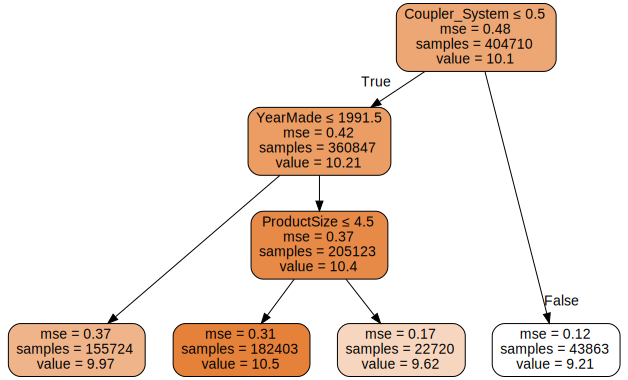

In [59]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

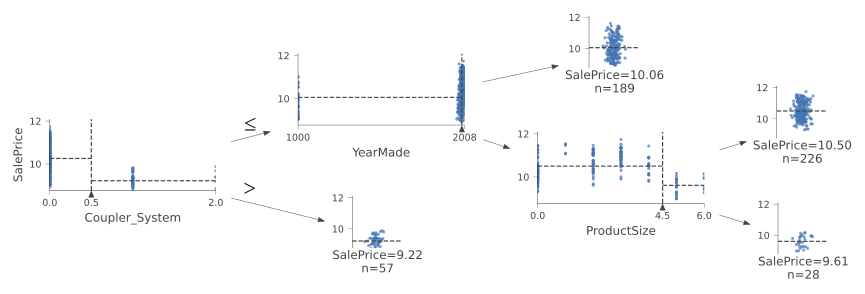

In [60]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [61]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

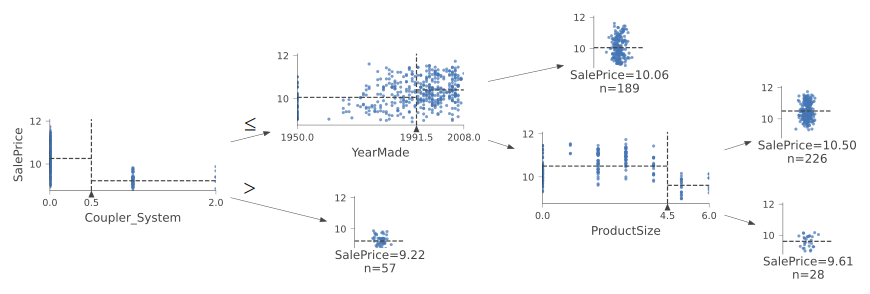

In [62]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs, y)

dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [66]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [64]:
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

In [67]:
m_rmse(m, xs, y)

1e-06

In [65]:
m_rmse(m, valid_xs, valid_y)

0.332913

In [68]:
m.get_n_leaves(), len(xs)

(324548, 404710)

In [69]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.248564, 0.323419)

In [70]:
m.get_n_leaves()

12397

### Creating a random forest model

> Indented block


- loss function
- model creation and fitting
- evaluating validation set

In [51]:
# pip install —pre -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn —U

In [52]:
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [71]:
m = rf(xs, y);

In [72]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.170939, 0.232793)

### Feature Importance and Removing Low Importance Variables

In [73]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [74]:
r_mse(preds.mean(0), valid_y)

0.232793

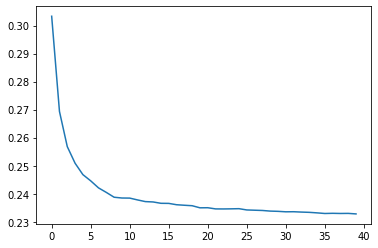

In [75]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

In [76]:
r_mse(m.oob_prediction_, y)

0.210763

In [77]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

In [78]:
preds.shape

(40, 7988)

In [79]:
preds_std = preds.std(0)

In [80]:
preds_std[:5]

array([0.26129882, 0.10398261, 0.0968259 , 0.26797764, 0.13376501])

In [81]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [82]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
57,YearMade,0.173532
6,ProductSize,0.118479
30,Coupler_System,0.117065
7,fiProductClassDesc,0.071110
54,ModelID,0.054292
65,saleElapsed,0.048844
3,fiSecondaryDesc,0.045884
31,Grouser_Tracks,0.041195
12,Enclosure,0.039437
32,Hydraulics_Flow,0.032725


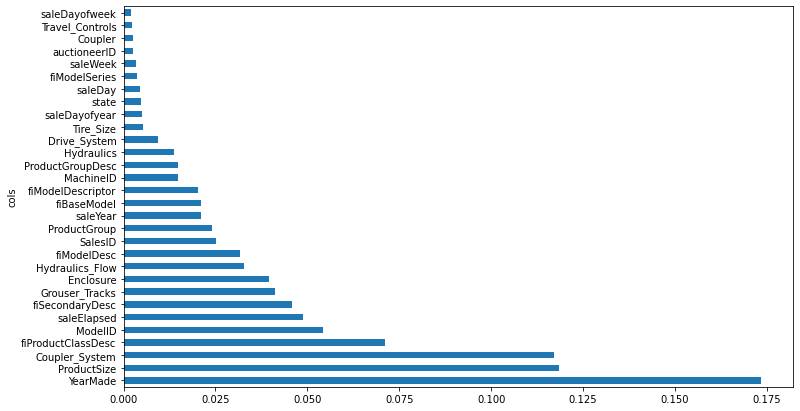

In [83]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

In [84]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

21

In [85]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [86]:
m = rf(xs_imp, y)

In [87]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.181313, 0.230502)

In [88]:
len(xs.columns), len(xs_imp.columns)

(66, 21)

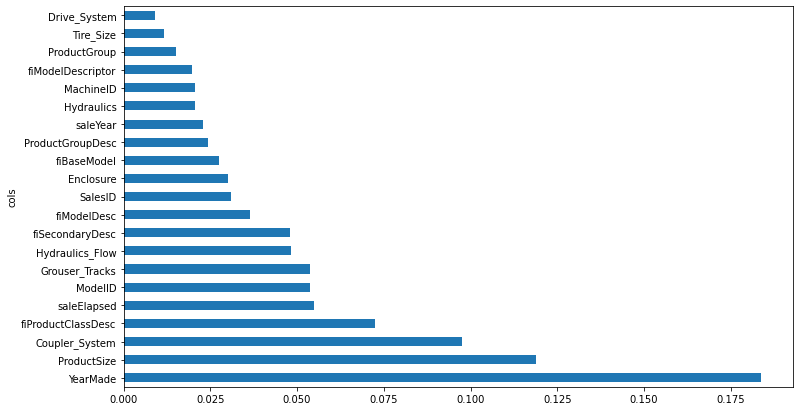

In [89]:
plot_fi(rf_feat_importance(m, xs_imp));

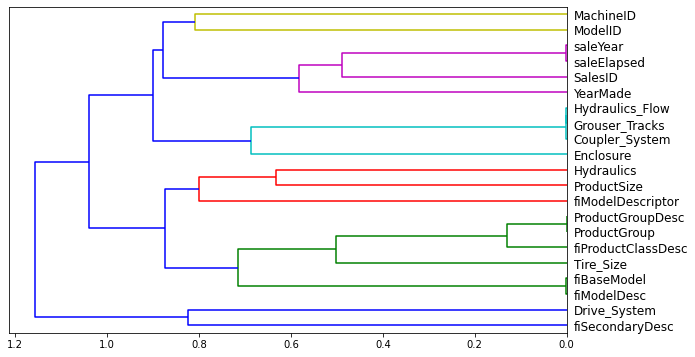

In [90]:
cluster_columns(xs_imp)

In [91]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
                              max_samples=50000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [92]:
get_oob(xs_imp)

0.8779005625151758

In [93]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed', 'ProductGroupDesc','ProductGroup',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks', 'Coupler_System')}

{'Coupler_System': 0.8772013400044534,
 'Grouser_Tracks': 0.8774880997899809,
 'Hydraulics_Flow': 0.8774352860626755,
 'ProductGroup': 0.8778740492067155,
 'ProductGroupDesc': 0.8769088554897561,
 'fiBaseModel': 0.8761327878824612,
 'fiModelDesc': 0.8755954753573445,
 'saleElapsed': 0.8722297896653314,
 'saleYear': 0.8767402142909457}

In [94]:
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8749782585570853

In [95]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [96]:
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [ ]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [97]:
m = rf(xs_final, y)
m_rmse(m, xs_final, y), m_rmse(m, valid_xs_final, valid_y)

(0.183289, 0.23233)

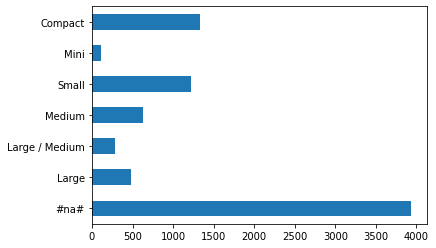

In [98]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

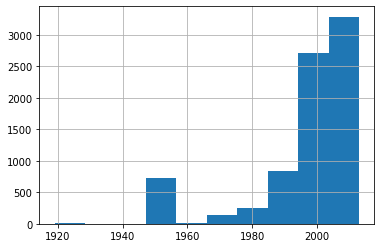

In [99]:
ax = valid_xs_final['YearMade'].hist()

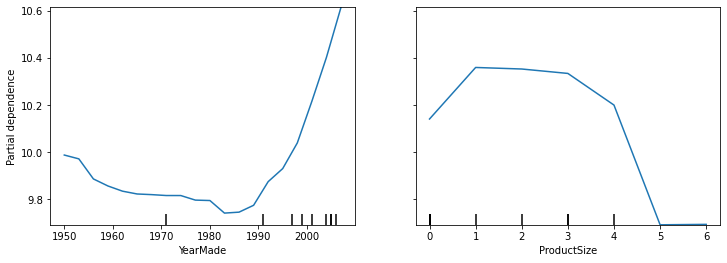

In [100]:
from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs_final, ['YearMade','ProductSize'],
                        grid_resolution=20, ax=ax);

In [102]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [103]:
row = valid_xs_final.iloc[:5]

In [104]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [105]:
prediction[0], bias[0], contributions[0].sum()

(array([9.94222849]), 10.104885761308193, -0.16265727202746502)

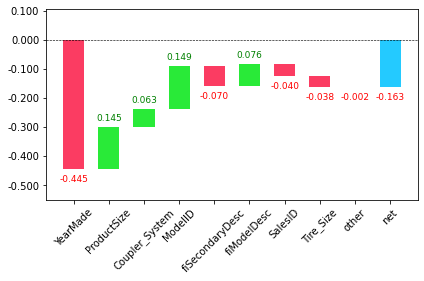

In [106]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08, 
          rotation_value=45,formatting='{:,.3f}');

## Refactor end to end tabular data with fastai `tabular_learner`

### Creating a Tabular Object for the deep learning model (`to_nn`)
- Reload DataFrame (`df_nn`) from dataset
- Handle data for ordinal, dates, missing, categorical, ...
- Remove variables you do not need or you do not want to use in the model
- Create your TabularPanda `to`

In [110]:
time_vars = ['SalesID','MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

In [115]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [107]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [111]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [112]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [113]:
cont_nn

['saleElapsed']

In [116]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176631, 0.229092)

In [117]:
df_nn_final[cat_nn].nunique()

YearMade                73
ProductSize              6
Coupler_System           2
fiProductClassDesc      74
ModelID               5281
fiSecondaryDesc        177
Enclosure                6
Hydraulics_Flow          3
fiModelDesc           5059
ProductGroup             6
fiModelDescriptor      140
Hydraulics              12
Drive_System             4
Tire_Size               17
dtype: int64

In [118]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse(m2, xs_filt2, y_filt), m_rmse(m2, valid_xs_time2, valid_y)

(0.176544, 0.229208)

In [119]:
cat_nn.remove('fiModelDescriptor')

### Creating and running the model

In [120]:
procs_nn = [Categorify, FillMissing, Normalize]

to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [121]:
dls = to_nn.dataloaders(1024)

In [122]:
y = to_nn.train.y
y.min(), y.max()

(8.465899467468262, 11.863582611083984)

In [123]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.0002754228771664202)

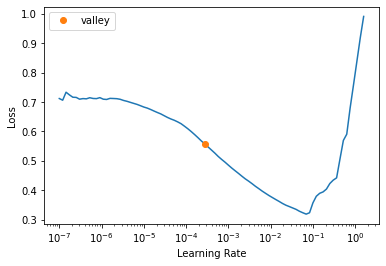

In [124]:
learn.lr_find()

In [125]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.063035,0.070167,00:42
1,0.053480,0.055075,00:42
2,0.047533,0.062025,00:42
3,0.043447,0.050535,00:41
4,0.040353,0.050283,00:42


In [126]:
preds, targs = learn.get_preds()
r_mse(preds,targs)

0.224238

In [127]:
learn.save('nn')

Path('models/nn.pth')

### Extract Embeddings (if you can !)

In [129]:
learn.model.embeds


ModuleList(
  (0): Embedding(73, 18)
  (1): Embedding(7, 5)
  (2): Embedding(3, 3)
  (3): Embedding(75, 18)
  (4): Embedding(5242, 194)
  (5): Embedding(178, 29)
  (6): Embedding(7, 5)
  (7): Embedding(4, 3)
  (8): Embedding(5060, 190)
  (9): Embedding(7, 5)
  (10): Embedding(13, 7)
  (11): Embedding(5, 4)
  (12): Embedding(18, 8)
)

In [130]:
save_pickle(path/'bluebook.embeds.pkl',learn.model.embeds)

In [ ]:
loadembeds = load_pickle(path/'bluebook.embeds.pkl')

## Assignment 2: Run additional code

### Random Forest

In this code, we will run some experiments to define how many estimators we should use for our Random Forest model.

Make sure you have run the notebook at least to the section **Creating the Decision Tree**.

Now we reload the *Tabular Object* `to` that we have create above.

In [131]:
to = load_pickle(path/'to.pkl')
# doc(to)

First we create our RF model

In [132]:
# Error Function / Metric
def r_mse(pred,y): 
    return round(math.sqrt(((pred-y)**2).mean()), 6)

def m_rmse(m, xs, y): 
    return r_mse(m.predict(xs), y)

In [133]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [134]:
# Set hyper parameters
n_estimators=40
max_samples=200_000
max_features=0.5
min_samples_leaf=5

# Create random forest model
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                          max_samples=max_samples, max_features=max_features,
                          min_samples_leaf=min_samples_leaf, oob_score=True)

In [135]:
# Fit model and evaluate RMSE for training and validation sets
m.fit(xs, y)
train_error, valid_error = m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)
train_error, valid_error

(0.171334, 0.232803)

A random forest model consisit of `n_estimators` independant decision trees (estimators), each considered "poor" estimators, but whose average is a good one.

We can peek into the performance of each of the 40 single estimators and compare with the overall error rate

In [137]:
rmse_train_single_tree = tensor([m_rmse(t, xs, y) for t in m.estimators_])
rmse_valid_single_tree = tensor([m_rmse(t, valid_xs, valid_y) for t in m.estimators_])

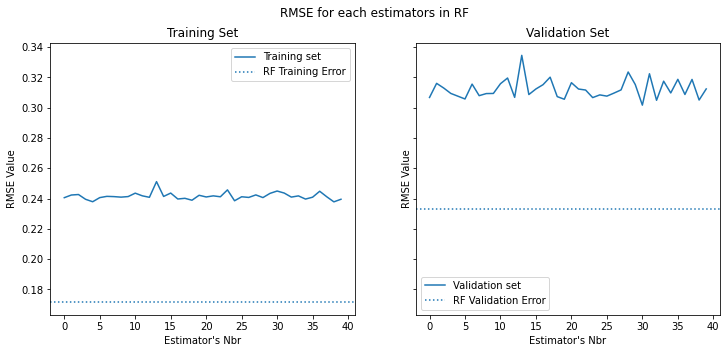

In [138]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharey=True)
fig.suptitle('RMSE for each estimators in RF')

axs[0].plot(range(n_estimators), rmse_train_single_tree, label='Training set')
axs[0].axhline(y=train_error, label='RF Training Error', ls=':')
axs[0].set_xlabel("Estimator's Nbr")
axs[0].set_ylabel("RMSE Value")
axs[0].set_title('Training Set')
axs[0].legend()

axs[1].plot(range(n_estimators), rmse_valid_single_tree, label='Validation set')
axs[1].axhline(y=valid_error, label='RF Validation Error', ls=':')
axs[1].set_xlabel("Estimator's Nbr")
axs[1].set_ylabel("RMSE Value")
axs[1].set_title('Validation Set')
axs[1].legend()

plt.show()

It is clear that the error rate for the Random Forest model is much better than the error rate for each of the decision trees (estimators)

**How many estimators should we use?**

To answer this question, we can just make trials using an increasing number of estimators, but only using a small amount of data (e.g. 20,000 samples) to get an idea of when increasing the number of estimators no longer give much improvement in error rate.

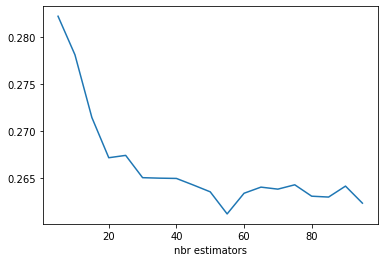

In [139]:
# Set hyper parameters
max_samples=20_000
max_features=0.5
min_samples_leaf=5

n_estimators = []
validation_error = []

for n in range(5, 100, 5):
    # Create random forest model
    m = RandomForestRegressor(n_jobs=-1, n_estimators=n,
                            max_samples=max_samples, max_features=max_features,
                            min_samples_leaf=min_samples_leaf, oob_score=False)
    m.fit(xs, y)
    e = m_rmse(m, valid_xs, valid_y)
    n_estimators.append(n)
    validation_error.append(e)

fig, ax = plt.subplots()
ax.plot(n_estimators, validation_error)
ax.set_xlabel('nbr estimators')
plt.show()

Now, let's check with the normal parameters (200,000) 20 and 40.

In [140]:
# Set hyper parameters
n_estimators=20
max_samples=200_000
max_features=0.5
min_samples_leaf=5

# Create random forest model
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                          max_samples=max_samples, max_features=max_features,
                          min_samples_leaf=min_samples_leaf, oob_score=True)

m.fit(xs, y)
m_rmse(m, valid_xs, valid_y)

0.237116

In [141]:
# Set hyper parameters
n_estimators=40
max_samples=200_000
max_features=0.5
min_samples_leaf=5

# Create random forest model
m = RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                          max_samples=max_samples, max_features=max_features,
                          min_samples_leaf=min_samples_leaf, oob_score=True)

m.fit(xs, y)
m_rmse(m, valid_xs, valid_y)

0.232952

## Assignment 3: Reflect on questionnaire

1. What is a continuous variable? age / price
1. What is a categorical variable? genres, sex
1. Provide two of the words that are used for the possible values of a categorical variable.  "levels" (or "categories" or "classes")
1. What is a "dense layer"? Combine our continuous embedding values with truly continuous input data in a straightforward manner: we just concatenate the variables
1. **How do entity embeddings reduce memory usage and speed up neural networks?** Especially for large datasets, representing the data as one-hot encoded vectors can be very inefficient (and also sparse). On the other hand, using entity embeddings allows the data to have a much more memory-efficient (dense) representation of the data. This will also lead to speed-ups for the model.
1. **What kinds of datasets are entity embeddings especially useful for? **categorical variables / It is especially useful for datasets with features that have high levels of cardinality (the features have lots of possible categories). Other methods often overfit to data like this.
1. What are the two main families of machine learning algorithms? a random forest, and a neural network
1. **Why do some categorical columns need a special ordering in their classes? How do you do this in Pandas?** Ordinal categories may inherently have some order and by using set_categories with the argument ordered=True and passing in the ordered list, this information represented in the pandas DataFrame.
1. **Summarize what a decision tree algorithm does.** 
The basic idea of what a decision tree algorithm does is to determine how to group the data based on “questions” that we ask about the data. That is, we keep splitting the data based on the levels or values of the features and generate predictions based on the average target value of the data points in that group. Here is the algorithm:

Loop through each column of the dataset in turn
For each column, loop through each possible level of that column in turn
Try splitting the data into two groups, based on whether they are greater than or less than that value (or if it is a categorical variable, based on whether they are equal to or not equal to that level of that categorical variable)
Find the average sale price for each of those two groups, and see how close that is to the actual sale price of each of the items of equipment in that group. That is, treat this as a very simple “model” where our predictions are simply the average sale price of the item’s group
After looping through all of the columns and possible levels for each, pick the split point which gave the best predictions using our very simple model
We now have two different groups for our data, based on this selected split. Treat each of these as separate datasets, and find the best split for each, by going back to step one for each group
Continue this process recursively, and until you have reached some stopping criterion for each group — for instance, stop splitting a group further when it has only 20 items in it.
1. **Why is a date different from a regular categorical or continuous variable, and how can you preprocess it to allow it to be used in a model?**
Some dates are different to others (ex: some are holidays, weekends, etc.) that cannot be described as just an ordinal variable. Instead, we can generate many different categorical features about the properties of the given date (ex: is it a weekday? is it the end of the month?, etc.) i.e. they can be periodic
1. Should you pick a random validation set in the bulldozer competition? If no, what kind of validation set should you pick? need to look at dates... later dates for validation and even later for test
1. What is pickle and what is it useful for? serialize an object so it can be stored - to cloud/to harddisk
1. How are `mse`, `samples`, and `values` calculated in the decision tree drawn in this chapter?  traversing the tree 
1. How do we deal with outliers, before building a decision tree? visualize it with dtreeviz - remove outliers or "bring them in"
1. How do we handle categorical variables in a decision tree?  We convert the categorical variables to integers, where the integers correspond to the discrete levels of the categorical variable. Apart from that, there is nothing special that needs to be done to get it to work with decision trees (unlike neural networks, where we use embedding layers).
1. **What is bagging?** Train multiple models on random subsets of the data, and use the ensemble of models for prediction.
1. What is the difference between `max_samples` and `max_features` when creating a random forest?
1. **If you increase `n_estimators` to a very high value, can that lead to overfitting? Why or why not?**  A higher n_estimators mean more decision trees are being used. However, since the trees are independent of each other, using higher n_estimators does not lead to overfitting.
1. In the section "Creating a Random Forest", just after `max_features`, why did `preds.mean(0)` give the same result as our random forest?
1. **What is "out-of-bag-error"?**  Only use the models not trained on the row of data when going through the data and evaluating the dataset. No validation set is needed.
1. Make a list of reasons why a model's validation set error might be worse than the OOB error. How could you test your hypotheses?  The major reason could be because the model does not generalize well. Related to this is the possibility that the validation data has a slightly different distribution than the data the model was trained on.
1. Explain why random forests are well suited to answering each of the following question:
   - How confident are we in our predictions using a particular row of data? Look at standard deviation between the estimators
   - For predicting with a particular row of data, what were the most important factors, and how did they influence that prediction?  Using the treeinterpreter package to check how the prediction changes as it goes through the tree, adding up the contributions from each split/feature. Use waterfall plot to visualize.
   - Which columns are the strongest predictors? Look at feature importance
   - How do predictions vary as we vary these columns? Look at partial dependence plots
1. **What's the purpose of removing unimportant variables?**   Sometimes, it is better to have a more interpretable model with less features, so removing unimportant variables helps in that regard.
1. What's a good type of plot for showing tree interpreter results? Waterfall plot
1. **What is the "extrapolation problem"?**  Hard for a model to extrapolate to data that’s outside the domain of the training data. This is particularly important for random forests. On the other hand, neural networks have underlying Linear layers so it could potentially generalize better.
1. How can you tell if your test or validation set is distributed in a different way than your training set? look at standard deviation / variance
1. Why do we ensure `saleElapsed` is a continuous variable, even although it has less than 9,000 distinct values?  This is a variable that changes over time, and since we want our model to extrapolate for future results, we make this a continuous variable.
1. What is "boosting"?  We train a model that underfits the dataset, and train subsequent models that predicts the error of the original model. We then add the predictions of all the models to get the final prediction.
1. **How could we use embeddings with a random forest? Would we expect this to help?**  Entity embeddings contains richer representations of the categorical features and definitely can improve the performance of other models like random forests. Instead of passing in the raw categorical columns, the entity embeddings can be passed into the random forest model.
1. Why might we not always use a neural net for tabular modeling?

We might not use them because they are the hardest to train and longest to train, and less well-understood. Instead, random forests should be the first choice/baseline, and neural networks could be tried to improve these results or add to an ensemble.